NaN counts before fixing:
 Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rolloff      0
spectral_entropy      0
spectral_contrast     0
label                 0
dtype: int64

NaN counts after fixing:
 Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rolloff      0
spectral_entropy      0
spectral_contrast    

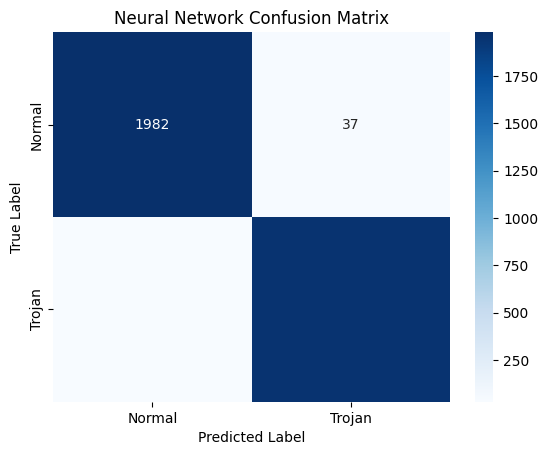

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# Load and Preprocess Data
df = pd.read_csv("IL_T1300_cleaned1.csv")
print("NaN counts before fixing:\n", df.isnull().sum())

# Fill missing values
df['spectral_contrast'].fillna(df['spectral_contrast'].mean(), inplace=True)
print("\nNaN counts after fixing:\n", df.isnull().sum())

# Split into normal and anomaly
df_normal = df[df['label'] == 0].copy()
df_anomaly = df[df['label'] == 1].copy()

# Feature extraction
def extract_features_labels(df_in):
    X = df_in.drop(columns=['label']).values
    y = df_in['label'].values
    return X, y

X, y = extract_features_labels(df)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, rf_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, rf_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, rf_pred) * 100:.2f}%")

# 2. Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.001, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
print("\nGradient Boosting Performance:")
print(f"Accuracy: {accuracy_score(y_test, gb_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, gb_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, gb_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, gb_pred) * 100:.2f}%")

# 3. Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
print("\nNaive Bayes Performance:")
print(f"Accuracy: {accuracy_score(y_test, nb_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, nb_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, nb_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, nb_pred) * 100:.2f}%")

# 4. Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_size = X_train.shape[1]
model = NeuralNet(input_size)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
patience = 10
counter = 0

# Training the neural network
for epoch in range(200):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Early stopping
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_train_tensor)
        _, val_pred = torch.max(val_outputs, 1)
        val_acc = accuracy_score(y_train, val_pred.numpy())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print("Early stopping activated.")
            break

# Testing the neural network
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_pred = torch.max(test_outputs, 1)

print("\nNeural Network Performance:")
print(f"Accuracy: {accuracy_score(y_test, test_pred.numpy()) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, test_pred.numpy()) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, test_pred.numpy()) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, test_pred.numpy()) * 100:.2f}%")

# Confusion Matrix for Neural Network
cm = confusion_matrix(y_test, test_pred.numpy())
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Trojan"], yticklabels=["Normal", "Trojan"])
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# Load and Preprocess Data
df = pd.read_csv("IL_T1300_cleaned1.csv")
print("NaN counts before fixing:\n", df.isnull().sum())

# Fill missing values
df['spectral_contrast'].fillna(df['spectral_contrast'].mean(), inplace=True)
print("\nNaN counts after fixing:\n", df.isnull().sum())

# Split into normal and anomaly
df_normal = df[df['label'] == 0].copy()
df_anomaly = df[df['label'] == 1].copy()

# Feature extraction
def extract_features_labels(df_in):
    X = df_in.drop(columns=['label']).values
    y = df_in['label'].values
    return X, y

X, y = extract_features_labels(df)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)
print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, rf_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, rf_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, rf_pred) * 100:.2f}%")
print("✅ rf_probs shape:", rf_probs.shape)

NaN counts before fixing:
 Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rolloff      0
spectral_entropy      0
spectral_contrast     0
label                 0
dtype: int64

NaN counts after fixing:
 Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rolloff      0
spectral_entropy      0
spectral_contrast    

In [2]:
# 2. Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.001, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_probs = gb_model.predict_proba(X_test) 
print("\nGradient Boosting Performance:")
print(f"Accuracy: {accuracy_score(y_test, gb_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, gb_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, gb_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, gb_pred) * 100:.2f}%")
print("✅ gb_probs shape:", gb_probs.shape)


Gradient Boosting Performance:
Accuracy: 98.40%
Precision: 97.76%
Recall: 99.04%
F1 Score: 98.40%
✅ gb_probs shape: (4000, 2)


In [3]:
# 3. Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_probs = nb_model.predict_proba(X_test) 
print("\nNaive Bayes Performance:")
print(f"Accuracy: {accuracy_score(y_test, nb_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, nb_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, nb_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, nb_pred) * 100:.2f}%")
print("✅ nb_probs shape:", nb_probs.shape) 


Naive Bayes Performance:
Accuracy: 97.97%
Precision: 97.74%
Recall: 98.18%
F1 Score: 97.96%
✅ nb_probs shape: (4000, 2)


Early stopping activated.

Neural Network Performance:
Accuracy: 98.47%
Precision: 98.00%
Recall: 98.94%
F1 Score: 98.47%
✅ nn_probs shape: (4000, 2)


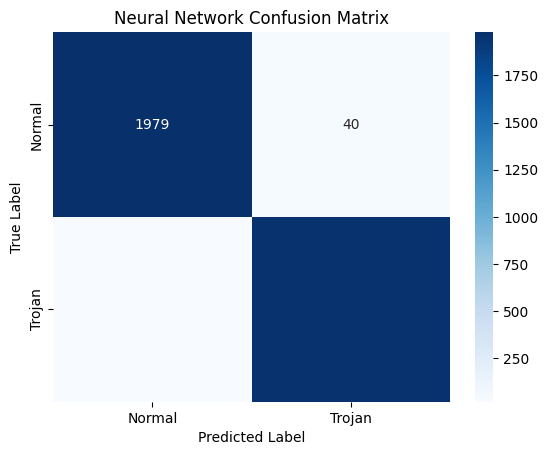

In [4]:
# 4. Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_size = X_train.shape[1]
model = NeuralNet(input_size)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
patience = 10
counter = 0

# Training the neural network
for epoch in range(200):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Early stopping
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_train_tensor)
        _, val_pred = torch.max(val_outputs, 1)
        val_acc = accuracy_score(y_train, val_pred.numpy())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print("Early stopping activated.")
            break

# Testing the neural network
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_pred = torch.max(test_outputs, 1)
    
# ✅ Get probabilities for stacking
with torch.no_grad():
    nn_softmax = torch.softmax(test_outputs, dim=1)
    nn_probs = nn_softmax.cpu().numpy()    
    

print("\nNeural Network Performance:")
print(f"Accuracy: {accuracy_score(y_test, test_pred.numpy()) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, test_pred.numpy()) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, test_pred.numpy()) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, test_pred.numpy()) * 100:.2f}%")
print("✅ nn_probs shape:", nn_probs.shape)
# Confusion Matrix for Neural Network
cm = confusion_matrix(y_test, test_pred.numpy())
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Trojan"], yticklabels=["Normal", "Trojan"])
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [5]:
# Cell 2: Load and Prepare Data
df = pd.read_csv("IL_T1300_cleaned1.csv")

# Check and drop NaN values
df.dropna(inplace=True)

# Separate features (X) and label (y)
X = df.drop(columns=['label']).values
y = df['label'].values

# Balance the dataset with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
print(f"Balanced dataset: {np.bincount(y_resampled)}")

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)



NameError: name 'RandomOverSampler' is not defined

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# ✅ Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Cell 2: Load and Prepare Data
df = pd.read_csv("IL_T1300_cleaned1.csv")

# Check and drop NaN values
df.dropna(inplace=True)

# Separate features (X) and label (y)
X = df.drop(columns=['label']).values
y = df['label'].values

# Balance the dataset with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
print(f"Balanced dataset: {np.bincount(y_resampled)}")

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)

Balanced dataset: [10000 10000]


In [9]:
# Cell 3: Create Sequences for LSTM
timesteps = 30  # Adjusted sequence length

def create_sequences(data, labels, seq_len=30):
    seqs, labs = [], []
    for i in range(len(data) - seq_len + 1):
        seqs.append(data[i : i + seq_len])
        labs.append(labels[i + seq_len - 1])
    return np.array(seqs), np.array(labs)

X_seq, y_seq = create_sequences(X_scaled, y_resampled, seq_len=timesteps)

print("Sequence X_seq shape:", X_seq.shape)
print("Sequence y_seq shape:", y_seq.shape)


Sequence X_seq shape: (19971, 30, 19)
Sequence y_seq shape: (19971,)


In [17]:
# Cell 4: Train-Test Split (Consistent with other models)
from sklearn.model_selection import train_test_split

# Use same random split method as RF/NN/etc.
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, shuffle=True
)

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape, "y_test shape:", y_test.shape)


X_train shape: (15976, 30, 19) X_test shape: (3995, 30, 19)
y_train shape: (15976,) y_test shape: (3995,)


In [18]:
# Cell 5: Prepare Tensors and DataLoader
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32).to(device)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.long).to(device)

batch_size = 32  # Reduced batch size for better gradient updates
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


In [19]:
# Cell 6: Define LSTM Model
class DeeperLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=2, num_layers=2, dropout=0.5):
        super(DeeperLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_step = lstm_out[:, -1, :]
        x = self.fc1(last_step)
        x = self.relu(x)
        out = self.fc2(x)
        return out

num_features = X.shape[1]
model = DeeperLSTM(input_dim=num_features).to(device)


In [20]:
# Cell 7: Define Weighted Loss and Optimizer
class_weights = torch.tensor([0.5, 1.5]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # Added L2 regularization

print("Criterion:", criterion)
print("Optimizer:", optimizer)


Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)


In [21]:
# Cell 8: Train the Model
epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(Xb)
        loss = criterion(outputs, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc  = 100.0 * correct / total
    print(f"Epoch {epoch}/{epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")


Epoch 1/100 | Loss: 0.2163 | Acc: 82.26%
Epoch 2/100 | Loss: 0.0095 | Acc: 99.89%
Epoch 3/100 | Loss: 0.0089 | Acc: 99.88%
Epoch 4/100 | Loss: 0.0089 | Acc: 99.90%
Epoch 5/100 | Loss: 0.0083 | Acc: 99.91%
Epoch 6/100 | Loss: 0.0075 | Acc: 99.92%
Epoch 7/100 | Loss: 0.0083 | Acc: 99.88%
Epoch 8/100 | Loss: 0.0065 | Acc: 99.92%
Epoch 9/100 | Loss: 0.0081 | Acc: 99.88%
Epoch 10/100 | Loss: 0.0075 | Acc: 99.91%
Epoch 11/100 | Loss: 0.0070 | Acc: 99.92%
Epoch 12/100 | Loss: 0.0068 | Acc: 99.92%
Epoch 13/100 | Loss: 0.0051 | Acc: 99.92%
Epoch 14/100 | Loss: 0.0064 | Acc: 99.92%
Epoch 15/100 | Loss: 0.0049 | Acc: 99.91%
Epoch 16/100 | Loss: 0.0056 | Acc: 99.92%
Epoch 17/100 | Loss: 0.0058 | Acc: 99.90%
Epoch 18/100 | Loss: 0.0043 | Acc: 99.95%
Epoch 19/100 | Loss: 0.0049 | Acc: 99.93%
Epoch 20/100 | Loss: 0.0055 | Acc: 99.92%
Epoch 21/100 | Loss: 0.0044 | Acc: 99.94%
Epoch 22/100 | Loss: 0.0048 | Acc: 99.94%
Epoch 23/100 | Loss: 0.0043 | Acc: 99.94%
Epoch 24/100 | Loss: 0.0041 | Acc: 99.94%
E

In [22]:
# Cell 9: Evaluate the Model
model.eval()
all_preds, all_true = [], []
lstm_probs_list = [] 
with torch.no_grad():
    for Xb, yb in test_loader:
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        lstm_probs_list.append(probs.cpu().numpy())
        _, predicted = torch.max(logits, 1)
        all_preds.append(predicted.cpu().numpy())
        all_true.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)
lstm_probs = np.concatenate(lstm_probs_list) 

acc  = accuracy_score(all_true, all_preds) * 100
prec = precision_score(all_true, all_preds, pos_label=1, zero_division=0) * 100
rec  = recall_score(all_true, all_preds, pos_label=1, zero_division=0) * 100
f1   = f1_score(all_true, all_preds, pos_label=1, zero_division=0) * 100

print("\n✅ Final Test Results:")
print(f"Accuracy:   {acc:.2f}%")
print(f"Precision:  {prec:.2f}%")
print(f"Recall:     {rec:.2f}%")
print(f"F1-score:   {f1:.2f}%")
print("✅ lstm_probs shape:", lstm_probs.shape)


✅ Final Test Results:
Accuracy:   99.95%
Precision:  100.00%
Recall:     99.90%
F1-score:   99.95%
✅ lstm_probs shape: (3995, 2)


In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os

# ------------------------------
# 1. Check for GPU
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Using device: {device}")

# ------------------------------
# 2. Load the Dataset
# ------------------------------
file_path = "IL_T1300_cleaned1.csv"
if not os.path.exists(file_path):
    print(f"❌ ERROR: File '{file_path}' not found! Place it in the same directory.")
    exit(1)

df = pd.read_csv(file_path)

# Rename 'Label' to 'label' if needed
df.rename(columns={'Label': 'label'}, inplace=True)

# ------------------------------
# 3. Handle Missing Values
# ------------------------------
print("Missing values per column before handling:\n", df.isnull().sum())

# Fill NaN values with column mean
df.fillna(df.mean(), inplace=True)

# Optional: Drop rows with any remaining NaNs
df.dropna(inplace=True)

print("Missing values per column after handling:\n", df.isnull().sum())

# ------------------------------
# 4. Separate Features & Labels
# ------------------------------
if 'label' not in df.columns:
    raise ValueError("❌ 'label' column is missing from the CSV. Please check your data.")

X = df.drop(columns=['label'])
y = df['label'].values  # 0 = Normal, 1 = Trojan (assuming binary)

# ------------------------------
# 5. Normalize Features
# ------------------------------
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print("✅ Features normalized.")

# ------------------------------
# 6. Build the Graph Edges
# ------------------------------

X_combined = np.vstack([X_train_np, X_test_np])
y_combined = np.hstack([y_train_np, y_test_np])
num_total = X_combined.shape[0] 
# (A) Temporal adjacency: connect each time step i -> i+1 (and i+1 -> i for undirected)
temporal_edges = []
for i in range(num_total - 1):
    temporal_edges.append([i, i + 1])
    temporal_edges.append([i + 1, i])

temporal_edges = np.array(temporal_edges).T

# (B) KNN adjacency
knn_graph = kneighbors_graph(X_combined, n_neighbors=5, mode="connectivity", include_self=False)
knn_coo = knn_graph.tocoo()
knn_edges = np.vstack([knn_coo.row, knn_coo.col])

# Combine edges
all_edges = np.concatenate([temporal_edges, knn_edges], axis=1)
edge_index = torch.tensor(all_edges, dtype=torch.long)

# ------------------------------
# 7. Create PyTorch Geometric Data
# ------------------------------
x_tensor = torch.tensor(X_combined, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_combined, dtype=torch.long).to(device)

data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor).to(device)
print("✅ Graph dataset created with temporal + KNN edges.")

# ------------------------------
# 8. Train/Test Split
# ------------------------------
from sklearn.model_selection import train_test_split

# Use the same random split for GNN as other models
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)

# Combine again for graph building
X_combined = np.vstack([X_train_np, X_test_np])
y_combined = np.hstack([y_train_np, y_test_np])

# Record train/test index masks
num_total = X_combined.shape[0]
num_train = X_train_np.shape[0]
train_mask = torch.zeros(num_total, dtype=torch.bool)
test_mask = torch.zeros(num_total, dtype=torch.bool)
train_mask[:num_train] = True
test_mask[num_train:] = True

# ------------------------------
# 9. Define GNN Model
# ------------------------------
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=2):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Initialize model, optimizer, loss
model = GNN(input_dim=X.shape[1], hidden_dim=256, output_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print("✅ GNN model initialized.")

# ------------------------------
# 10. Train the Model
# ------------------------------
epochs = 2000
print("\n✅ Training Started...")

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    out = model(data)  # shape: [num_samples, 2]
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Compute training accuracy
    train_pred = out[train_mask].argmax(dim=1)
    train_acc = (train_pred == data.y[train_mask]).float().mean().item()

    if (epoch + 1) % 100 == 0:  # Print every 100 epochs
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.2%}")

print("\n✅ Training completed.")

# ------------------------------
# 11. Save the Model
# ------------------------------
torch.save(model.state_dict(), "trojan_gnn_model.pth")
print("\n✅ Model saved as 'trojan_gnn_model.pth'.")

# ------------------------------
# 12. Evaluate the Model
# ------------------------------
model.eval()
with torch.no_grad():
    out = model(data)
    gnn_softmax = torch.softmax(out[test_mask], dim=1)
    gnn_probs = gnn_softmax.cpu().numpy()  # (num_test_samples, 2)
    test_pred = out[test_mask].argmax(dim=1)

# Compute Metrics
y_true = data.y[test_mask].cpu().numpy()
y_pred = test_pred.cpu().numpy()

accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, zero_division=0) * 100
recall = recall_score(y_true, y_pred, zero_division=0) * 100
f1 = f1_score(y_true, y_pred, zero_division=0) * 100

# Print Results
print("\n🎯 Model Performance on Test Nodes:")
print(f"✅ Accuracy:  {accuracy:.2f}%")
print(f"✅ Precision: {precision:.2f}%")
print(f"✅ Recall:    {recall:.2f}%")
print(f"✅ F1-score:  {f1:.2f}%")
print("✅ gnn_probs shape:", gnn_probs.shape)



✅ Using device: cuda
Missing values per column before handling:
 Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rolloff      0
spectral_entropy      0
spectral_contrast     0
label                 0
dtype: int64
Missing values per column after handling:
 Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rollo

NameError: name 'X_train_np' is not defined

In [25]:
# Corrected and complete GNN code with aligned train/test split

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os

# 1. Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Using device: {device}")

# 2. Load the Dataset
file_path = "IL_T1300_cleaned1.csv"
if not os.path.exists(file_path):
    print(f"❌ ERROR: File '{file_path}' not found! Place it in the same directory.")
    exit(1)

df = pd.read_csv(file_path)
df.rename(columns={'Label': 'label'}, inplace=True)

# 3. Handle Missing Values
print("Missing values per column before handling:\n", df.isnull().sum())
df.fillna(df.mean(), inplace=True)
df.dropna(inplace=True)
print("Missing values per column after handling:\n", df.isnull().sum())

# 4. Separate Features & Labels
if 'label' not in df.columns:
    raise ValueError("❌ 'label' column is missing from the CSV. Please check your data.")

X = df.drop(columns=['label'])
y = df['label'].values

# 5. Normalize Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print("✅ Features normalized.")

# 5.5 Train/Test Split (Aligned with Other Models)
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)

# 6. Build the Graph Edges
X_combined = np.vstack([X_train_np, X_test_np])
y_combined = np.hstack([y_train_np, y_test_np])
num_total = X_combined.shape[0]

# Temporal adjacency
temporal_edges = []
for i in range(num_total - 1):
    temporal_edges.append([i, i + 1])
    temporal_edges.append([i + 1, i])
temporal_edges = np.array(temporal_edges).T

# KNN adjacency
knn_graph = kneighbors_graph(X_combined, n_neighbors=5, mode="connectivity", include_self=False)
knn_coo = knn_graph.tocoo()
knn_edges = np.vstack([knn_coo.row, knn_coo.col])

# Combine edges
all_edges = np.concatenate([temporal_edges, knn_edges], axis=1)
edge_index = torch.tensor(all_edges, dtype=torch.long)

# 7. Create PyTorch Geometric Data
x_tensor = torch.tensor(X_combined, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_combined, dtype=torch.long).to(device)
data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor).to(device)

# Define train/test masks
train_mask = torch.zeros(num_total, dtype=torch.bool)
test_mask = torch.zeros(num_total, dtype=torch.bool)
train_mask[:len(X_train_np)] = True
test_mask[len(X_train_np):] = True

print("✅ Graph dataset created with temporal + KNN edges.")

# 8. Define GNN Model
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=2):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Initialize model, optimizer, loss
model = GNN(input_dim=X.shape[1], hidden_dim=256, output_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print("✅ GNN model initialized.")

# 9. Train the Model
epochs = 2000
print("\n✅ Training Started...")

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    train_pred = out[train_mask].argmax(dim=1)
    train_acc = (train_pred == data.y[train_mask]).float().mean().item()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.2%}")

print("\n✅ Training completed.")

# 10. Save the Model
torch.save(model.state_dict(), "trojan_gnn_model.pth")
print("\n✅ Model saved as 'trojan_gnn_model.pth'.")

# 11. Evaluate the Model and Extract Probabilities
model.eval()
with torch.no_grad():
    out = model(data)
    gnn_softmax = torch.softmax(out[test_mask], dim=1)
    gnn_probs = gnn_softmax.cpu().numpy()
    test_pred = gnn_softmax.argmax(dim=1)

y_true = data.y[test_mask].cpu().numpy()
y_pred = test_pred.cpu().numpy()

accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, zero_division=0) * 100
recall = recall_score(y_true, y_pred, zero_division=0) * 100
f1 = f1_score(y_true, y_pred, zero_division=0) * 100

print("\n🎯 Model Performance on Test Nodes:")
print(f"✅ Accuracy:  {accuracy:.2f}%")
print(f"✅ Precision: {precision:.2f}%")
print(f"✅ Recall:    {recall:.2f}%")
print(f"✅ F1-score:  {f1:.2f}%")
print("✅ gnn_probs shape:", gnn_probs.shape)



✅ Using device: cuda
Missing values per column before handling:
 Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rolloff      0
spectral_entropy      0
spectral_contrast     0
label                 0
dtype: int64
Missing values per column after handling:
 Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rollo

In [26]:
# Make sure all shapes are (3995, 2)
X_meta = np.hstack([
    rf_probs,
    gb_probs,
    nb_probs,
    nn_probs,
    lstm_probs,
    gnn_probs
])

print("✅ X_meta shape:", X_meta.shape)  # Should be (3995, 12)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4000 and the array at index 4 has size 3995

In [27]:
print("rf_probs:", rf_probs.shape)
print("gb_probs:", gb_probs.shape)
print("nb_probs:", nb_probs.shape)
print("nn_probs:", nn_probs.shape)
print("lstm_probs:", lstm_probs.shape)
print("gnn_probs:", gnn_probs.shape)
print("y_test:", y_test.shape)


rf_probs: (4000, 2)
gb_probs: (4000, 2)
nb_probs: (4000, 2)
nn_probs: (4000, 2)
lstm_probs: (3995, 2)
gnn_probs: (4000, 2)
y_test: (3995,)


In [28]:
target_len = 3995  # Match LSTM and y_test

rf_probs   = rf_probs[:target_len]
gb_probs   = gb_probs[:target_len]
nb_probs   = nb_probs[:target_len]
nn_probs   = nn_probs[:target_len]
gnn_probs  = gnn_probs[:target_len]
y_test     = y_test[:target_len]


In [29]:
X_meta = np.hstack([
    rf_probs,
    gb_probs,
    nb_probs,
    nn_probs,
    lstm_probs,
    gnn_probs
])
print("✅ X_meta shape:", X_meta.shape)  # Should be (3995, 12)


✅ X_meta shape: (3995, 12)


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

meta_clf = LogisticRegression(max_iter=1000)
meta_clf.fit(X_meta, y_test)

# Predict and evaluate
y_meta_pred = meta_clf.predict(X_meta)

acc  = accuracy_score(y_test, y_meta_pred) * 100
prec = precision_score(y_test, y_meta_pred) * 100
rec  = recall_score(y_test, y_meta_pred) * 100
f1   = f1_score(y_test, y_meta_pred) * 100

print("\n🔗 Stacking Ensemble Performance:")
print(f"✅ Accuracy:  {acc:.2f}%")
print(f"✅ Precision: {prec:.2f}%")
print(f"✅ Recall:    {rec:.2f}%")
print(f"✅ F1-score:  {f1:.2f}%")



🔗 Stacking Ensemble Performance:
✅ Accuracy:  99.95%
✅ Precision: 100.00%
✅ Recall:    99.90%
✅ F1-score:  99.95%


In [31]:
import pandas as pd

df_meta = pd.DataFrame(X_meta, columns=[
    'rf_0', 'rf_1', 'gb_0', 'gb_1', 'nb_0', 'nb_1',
    'nn_0', 'nn_1', 'lstm_0', 'lstm_1', 'gnn_0', 'gnn_1'
])
df_meta['true_label'] = y_test
df_meta['ensemble_pred'] = y_meta_pred

df_meta.to_csv("stacking_results.csv", index=False)
print("📁 Saved stacking results to 'stacking_results.csv'")


📁 Saved stacking results to 'stacking_results.csv'


In [32]:
import joblib

joblib.dump(meta_clf, 'stacking_meta_model.pkl')
print("📦 Meta-classifier saved as 'stacking_meta_model.pkl'")


📦 Meta-classifier saved as 'stacking_meta_model.pkl'


In [34]:
metrics = {
    'Random Forest': accuracy_score(y_test, rf_pred[:len(y_test)]) * 100,
    'Gradient Boost': accuracy_score(y_test, gb_pred[:len(y_test)]) * 100,
    'Naive Bayes': accuracy_score(y_test, nb_pred[:len(y_test)]) * 100,
    #'Neural Net': accuracy_score(y_test, nn_pred[:len(y_test)]) * 100,
    'LSTM': accuracy_score(y_test, all_preds) * 100,  # all_preds = final lstm predictions
    'GNN': accuracy_score(y_test, gnn_probs.argmax(axis=1)) * 100,
    'Ensemble': accuracy_score(y_test, y_meta_pred) * 100
}


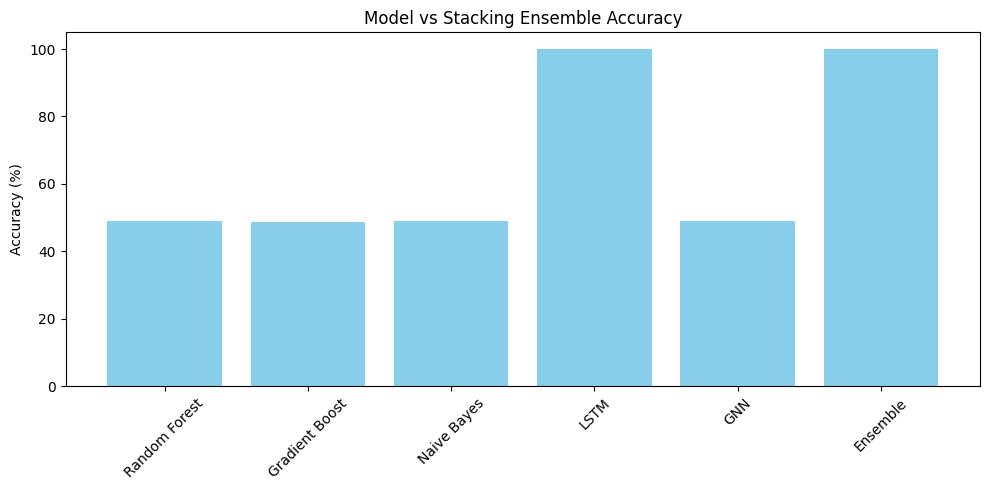

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylabel("Accuracy (%)")
plt.title("Model vs Stacking Ensemble Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [36]:
from scipy.stats import ttest_rel

# 1 if prediction is correct, 0 otherwise
rf_correct = (rf_pred[:len(y_test)] == y_test).astype(int)
meta_correct = (y_meta_pred == y_test).astype(int)

t_stat, p_val = ttest_rel(meta_correct, rf_correct)
print(f"🔬 Paired t-test: t = {t_stat:.4f}, p = {p_val:.4f}")


🔬 Paired t-test: t = 64.2670, p = 0.0000


In [37]:
from scipy.stats import wilcoxon

w_stat, p_val = wilcoxon(meta_correct, rf_correct)
print(f"📊 Wilcoxon test: W = {w_stat:.4f}, p = {p_val:.4f}")


📊 Wilcoxon test: W = 0.0000, p = 0.0000
